In [2]:
# Binary image Classification
# Classify image into normal or malignant
# Identify metastatic cancer in small image patches taken from 
# larger digital pathology scans

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir ./gdrive/MyDrive/histopathologic_data/train_labels.csv

In [6]:
!ls gdrive/MyDrive/histopathologic_data/

models	test  train  train_labels2.csv	train_labels.csv


In [5]:
import pandas as pd
path2csv = "./gdrive/MyDrive/histopathologic_data/train_labels2.csv"
labels_df = pd.read_csv(path2csv)
labels_df.head()

,Unnamed: 0,id,label
0,560,00b25ec6689474e5d5a471e50094ccf529e4173d,0
1,1983,0011eb0c482ab5752cc6e84561f50200d7c1db30,1
2,2349,00b6e7c821052398e701db1b05c5e0ac212064a1,0
3,4253,00da85d977c21ae27cfed3f91bad205be7fa9c16,0
4,4526,001522991c0eab8b47769f2a0f852bc0891c3af2,1


In [7]:
#count number of normal and mallignet cases
print(labels_df['label'].value_counts())

0    142
1    100
Name: label, dtype: int64


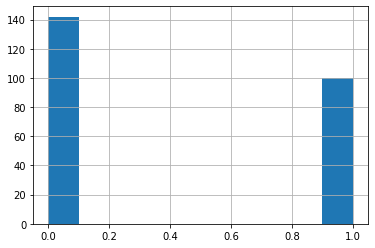

In [8]:
# plot hitogram for the labels
%matplotlib inline
labels_df['label'].hist()

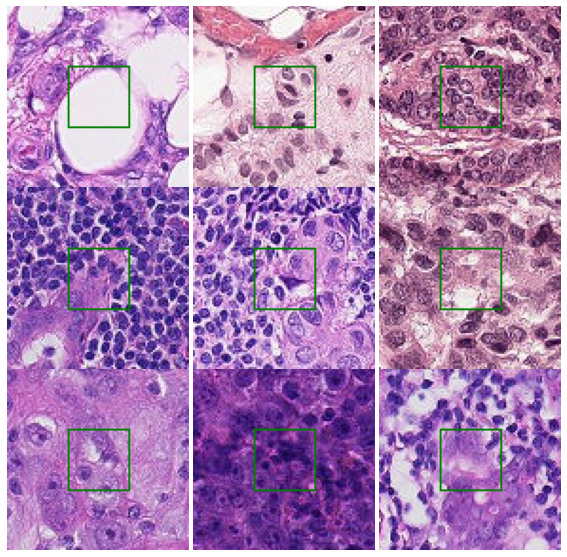

In [9]:
# Visualizing the images
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np 
import os 

#get ids for the malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

path2train = "./gdrive/MyDrive/histopathologic_data/train"
#flag to show color or grayscale image
color=True

# set the figure size
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3,3

for i , id_ in enumerate(malignantIds[:nrows*ncols]):
  full_filesnames = os.path.join(path2train, id_+'.tif')
  img = Image.open(full_filesnames)
  draw = ImageDraw.Draw(img)
  draw.rectangle(((32,32),(64,64)), outline="green")
  plt.subplot(nrows, ncols, i+1)
  if color is True:
    plt.imshow(np.array(img))
  else:
    plt.imshow(np.array(img)[:,:,0], cmap="gray")
  plt.axis('off')  


In [10]:
img_in_train = []
img_in_train = os.listdir(path2train)
img_in_train_name = [x.replace('.tif','') for x in img_in_train]


In [ ]:
labels_df_for_train = labels_df[labels_df['id'].isin(img_in_train_name)]


In [ ]:
labels_df_for_train.to_csv('./gdrive/MyDrive/histopathologic_data/train_labels2.csv')

In [11]:
from PIL import Image 
import torch 
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

# Fix the random seed
torch.manual_seed(0)

class histoCancerDataset(Dataset):
  def __init__(self,data_dir, transform, data_type='train'):
    # Path to images
    path2data = os.path.join(data_dir, data_type)
    # Get the list images in the data_type folder
    # when train , this will list all the files in train folder
    filesnames = os.listdir(path2data)
    self.full_filesnames = [os.path.join(path2data,f) for f in filesnames]

    # labels are in csv fila name train_labesl.csv
    csv_filename = data_type+'_labels2.csv'
    path2csvLabels = os.path.join(data_dir, csv_filename)
    labels_df = pd.read_csv(path2csvLabels)

    # sset the dataframe indec to id
    labels_df.set_index('id', inplace=True)
    
    # obtain labels from data frame
    self.labels = [labels_df.loc[filename[:-4]].values[1] for filename in filesnames]
    self.transform = transform

  def __len__(self):
      #return thr size of dataset
      return len(self.full_filesnames)

  def __getitem__(self, idx):
      # open image , apply transform and reith with label
      image = Image.open(self.full_filesnames[idx])
      image = self.transform(image)
      return image,self.labels[idx]


In [12]:
# Transformer that converts PIL image into pytorch tensor
data_transformer = transforms.Compose([transforms.ToTensor()])


In [13]:
# # define an object of the custom dataset for the train folder
data_dir = 'gdrive/MyDrive/histopathologic_data/'
histo_dataset = histoCancerDataset(data_dir,data_transformer, "train")
len(histo_dataset)

242

In [14]:
img, label = histo_dataset[1]
print(img.shape, torch.min(img), torch.max(img))
print(label)

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)
0


In [15]:
# split the dataset into training and validation set
from torch.utils.data import random_split
# calculate the length of the train and validation set
len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo-len_train

train_ds, val_ds = random_split(histo_dataset,[len_train,len_val])
print('Train dataset length: ',len(train_ds))
print('Validation dataset length: ',len(val_ds))

Train dataset length:  193
Validation dataset length:  49


In [16]:
# get length of the training dataset image
for x,y in train_ds:
  print(x.shape,y)
  break

torch.Size([3, 96, 96]) 0


In [17]:
for x, y in val_ds:
  print(x.shape, y)
  break

torch.Size([3, 96, 96]) 1


image indices: [172  47 117 192]
torch.Size([3, 100, 394])


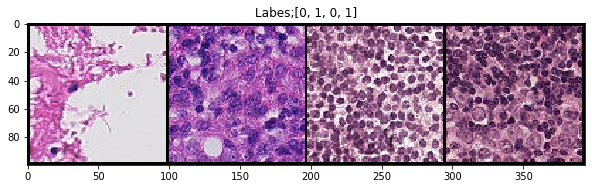

In [18]:
# Display samples from train_ds
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inlne
np.random.seed(0)

# Helper function to show image
def showw(img, y, color=False):
  # Convert tensor to numpy array
  npimg = img.numpy()
  #convert to H*W*C shape
  npimg_tr = np.transpose(npimg, (1,2,0))

  if color==False:
    npimg_tr= npimg_tr[:,:,0]
    plt.imshow(npimg_tr, interpolation='nearest',cmap='gray')
  else:
    plt.imshow(npimg_tr, interpolation='nearest')
  plt.title('Labes;'+str(y))

#Create grid for sample images
grid_size=4
rnd_inds = np.random.randint(0,len(train_ds), grid_size)
print("image indices:", rnd_inds)
x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]
x_grid_train = utils.make_grid(x_grid_train, nrows=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize']=(10,5)
showw(x_grid_train, y_grid_train,color=True)


images indices : [ 3  3 39  9]
torch.Size([3, 100, 394])


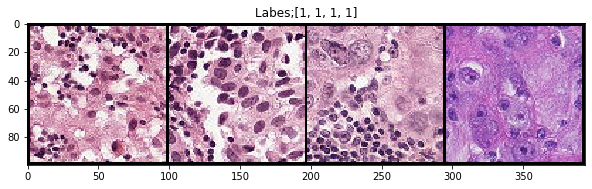

In [19]:
# Samples from val ds
grid_size=4
rnd_inds = np.random.randint(0,len(val_ds), grid_size)
print('images indices :', rnd_inds)
x_grid_val = [val_ds[i][0] for i in range(grid_size)]
y_grid_val = [val_ds[i][1] for i in range(grid_size)]

x_grid_val = utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
showw(x_grid_val, y_grid_val, color=True)


Transformaing data
Image transformation and image augmentation are necessary for training.
- Resize, normalize or expand the data
- Typical transformation include horizontal and vertical flipping, rotation, resizing
- The tranformtion can be done without changing the label
- Doing tranformation on the fly duing training

In [20]:
train_transformer = transforms.Compose([
                                        transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              transforms.RandomRotation(45),
                              transforms.RandomResizedCrop(96,scale=(0.8,1.0), ratio=(1.0,1.0)),
                              transforms.ToTensor()])
# For validation dataset we don't need any augmentation
val_transformer = transforms.Compose([transforms.ToTensor()])

# Overwrite transform functions of train_ds and val_ds
train_ds.transform = train_transformer
val_ds.transform=val_transformer

Create dataloader

In [21]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=True)

# Extrach a batch from training data
for x,y in train_dl:
  print(x.shape)
  print(y.shape)
  break
for x,y in val_dl:
  print(x.shape)
  print(y.shape)
  break



torch.Size([32, 3, 96, 96])
torch.Size([32])
torch.Size([49, 3, 96, 96])
torch.Size([49])


Building the Classification Model
The model will have 4 convolutional layers and 2 fully connected layers.
After the comvolution layer, there is a pooling layer

In [22]:
# Create baslines for valiation sets
# get labels for the validation set
y_val = [y for _,y in val_ds]

# Function to calcualte the accuracy
def accuracy(labels, out):
  return np.sum(out==labels)/float(len(labels))

# accuracy all zeros predictions
acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print('Accuracy of all zeros :',acc_all_zeros)

acc_all_ones = accuracy(y_val, np.ones_like(y_val))
print("Accuracy all ones : ",acc_all_ones)

acc_random = accuracy(y_val, np.random.randint(2, size=len(y_val)))
print('Accuracy random:',acc_random)

Accuracy of all zeros : 0.4489795918367347
Accuracy all ones :  0.5510204081632653
Accuracy random: 0.40816326530612246


In [23]:
import torch.nn as nn 
import torch.nn.functional as F

# Helper function to calculate the output size of CNN layer
def findConv2dOutShape(H_in, W_in, conv, pool=2):
  # get conv arguments
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation

  H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
  W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

  if pool:
    H_out/=pool
    W_out/=pool
  return int(H_out), int(W_out)

#Example
conv1 = nn.Conv2d(3,8, kernel_size=3)
h,w = findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self,params):
    super(Net, self).__init__()
    C_in, H_in, W_in = params["input_shape"]
    init_f = params['initial_filters']
    num_fc1 = params['num_fc1']
    num_classes = params['num_classes']
    self.dropout_rate = params['dropout_rate']

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w = findConv2dOutShape(H_in, W_in, self.conv1)
    
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w = findConv2dOutShape(h,w,self.conv2)

    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h, w = findConv2dOutShape(h,w,self.conv3)

    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h,w = findConv2dOutShape(h,w,self.conv4)

    # compute the flatten size
    self.num_flatten = h*w*8*init_f

    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x,2,2)
    x = x.view(-1, self.num_flatten)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout_rate, training= self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

params_model = {
    'input_shape': (3,96,96),
    'initial_filters': 8,
    'num_fc1':100,
    'dropout_rate':0.25,
    'num_classes':2}

cnn_model = Net(params_model)

In [25]:
# Move devie to gpu
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
  cnn_model.to(device)

In [26]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [27]:
print(next(cnn_model.parameters()).device)

cpu


In [28]:
loss_func = nn.NLLLoss(reduction='sum')

# Fix the random seed
torch.manual_seed(0)

n,c = 8,2
y = torch.rand(n,c,requires_grad=True)
print(y)
ls_f = nn.LogSoftmax(dim=1)
y_out = ls_f(y)
print(y_out)
print(y_out.shape)

tensor([[0.4963, 0.7682],
        [0.0885, 0.1320],
        [0.3074, 0.6341],
        [0.4901, 0.8964],
        [0.4556, 0.6323],
        [0.3489, 0.4017],
        [0.0223, 0.1689],
        [0.2939, 0.5185]], requires_grad=True)
tensor([[-0.8383, -0.5664],
        [-0.7152, -0.6716],
        [-0.8698, -0.5431],
        [-0.9168, -0.5105],
        [-0.7854, -0.6087],
        [-0.7199, -0.6671],
        [-0.7691, -0.6226],
        [-0.8118, -0.5871]], grad_fn=<LogSoftmaxBackward0>)
torch.Size([8, 2])


In [29]:
target = torch.randint(c,size=(n,))
print('target: ',target)
loss = loss_func(y_out, target)
print(loss.item())

loss.backward()
print(y.data)

target:  tensor([0, 0, 0, 1, 0, 1, 1, 0])
5.820520877838135
tensor([[0.4963, 0.7682],
        [0.0885, 0.1320],
        [0.3074, 0.6341],
        [0.4901, 0.8964],
        [0.4556, 0.6323],
        [0.3489, 0.4017],
        [0.0223, 0.1689],
        [0.2939, 0.5185]])


One helpful tool in torch.optim package is the learning schedules.
Learning schedules tools automatically adjust the learning rate during training to imporve model performance

In [30]:
from torch import optim 
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']
current_lr = get_lr(opt)
print('current lr = {}'.format(current_lr))

current lr = 0.0003


In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5,
                                 patience=20,verbose=1)

for i in range(50):
  lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.


In [32]:
# Helper functions for training and validation

# 1. count the number of correct prediction per batch

def metrics_batch(output, target):
  # get the outpur class
  pred = output.argmax(dim=1, keepdim=True)
  # compare the output class with the larget class
  corrects = (pred==target).sum().item()
  return corrects

# 2. Compute the loass per batch 
def loss_batch(loss_func, output, target, opt=None):
  loss = loss_func(output, target)
  with torch.no_grad():
    metric_b = metrics_batch(output, target)
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
  return loss.item(), metric_b

# 3. Compute the loss and metric for entire batch or epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)
  loss_b = 0.0
  metric = 0.0

  for xb, yb in dataset_dl:
    xb = xb.to(device)
    yb = yb.to(device)

    # get the model output
    output = model(xb)

    # get the loss per batch
    loss_b, metric_b = loss_batch(loss_func,output, yb, opt)

    # update the running loss
    running_loss += loss_b 
    # update the mertic
    if metric_b is not None:
      running_metric += metric_b
    # break the loop for sanity check
    if sanity_check is True:
      break
    #loss avrage
  loss = running_loss/float(len_data)
  #average metric value
  metric = running_metric/float(len_data)

  return loss, metric
  

In [33]:
# Train and validation function
def train_val(model,params):
  # extract the model parameters
  num_epochs = params['num_epochs']
  loss_func = params['loss_func']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  # dictionary to keep the history of loss and accuracy
  loss_history = {'train':[],'val':[]}
  metric_history = {'train':[], 'val':[]}

  # Initialize the best loss to a large value
  best_loss = float('inf')

  # Loop to calculate the training loss over an epoch
  for epoch in range(num_epochs):
    # get the current learning rate
    current_lr = get_lr(opt)
    print('Epoch: ',epoch,' Current Learning Rate: ', current_lr )

    # Training mode
    model.train()
    train_loss, train_metric = loss_epoch(model, loss_func,train_dl, sanity_check,opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # Evaluation for validation data
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

     # Collect the loss and accuracy  
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    # Store the best 
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print('Copied best model weights')

    # Learning rate Schedule
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print("Loading best model_weights")
      model.load_state_dict(best_model_wts)
    
    # Print the loss and accuracy and return the trained model
    print('Train Loss: ',train_loss, ' Validation Loss: ',val_loss, ' Val Acc: ', val_metric)
    print('-'*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [34]:
import copy
loss_func = nn.NLLLoss(reduction='sum')
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=True)

params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl': val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'gdrive/MyDrive/histopathologic_data/models/weights.pt'
}



In [35]:
cnn_model,loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch:  0  Current Learning Rate:  0.0003
Copied best model weights
Train Loss:  0.6817962196824464  Validation Loss:  0.7031861908581792  Val Acc:  22.0
----------
Epoch:  1  Current Learning Rate:  0.0003
Train Loss:  0.6735066851803676  Validation Loss:  0.7181432295818718  Val Acc:  22.0
----------
Epoch:  2  Current Learning Rate:  0.0003
Train Loss:  0.6662471820962244  Validation Loss:  0.7462796581034757  Val Acc:  22.0
----------
Epoch:  3  Current Learning Rate:  0.0003
Train Loss:  0.6603998296310247  Validation Loss:  0.7649156998614876  Val Acc:  22.0
----------
Epoch:  4  Current Learning Rate:  0.0003
Train Loss:  0.6610875281027562  Validation Loss:  0.7424338204520089  Val Acc:  22.0
----------
Epoch:  5  Current Learning Rate:  0.0003
Train Loss:  0.6588822692787092  Validation Loss:  0.7388189666125239  Val Acc:  22.0
----------
Epoch:  6  Current Learning Rate:  0.0003
Train Loss:  0.6578810449708928  Validation Loss:  0.7366065979003906  Val Acc:  22.0
----------
E

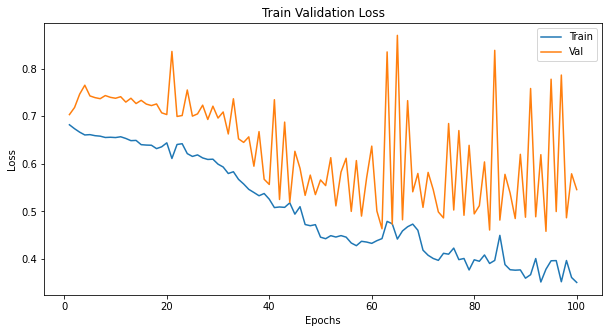

In [36]:
# Plotting

# Train validation progress
num_epochs = params_train['num_epochs']
 # Plot the progress
plt.title('Train Validation Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='Train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='Val')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

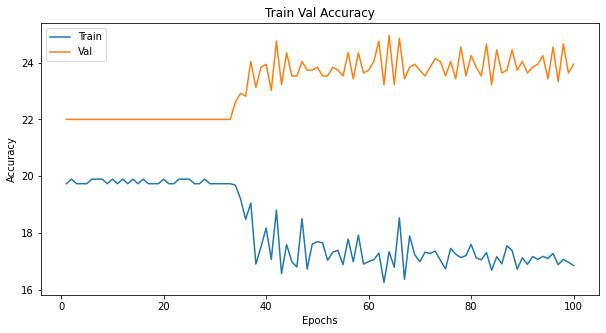

In [37]:
# Plot the accuracy
plt.title('Train Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='Train')
plt.plot(range(1,num_epochs+1), metric_hist['val'], label='Val')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()


Deploying the Model

In [38]:
#Create an object of the class Net and load the stored weigts into the model
# model parameters
params_model = {
    "input_shape":(3,96,96),
    "initial_filters":8,
    "num_fc1":100,
    "dropout_rate":0.25,
    "num_classes":2
}
# Initialoze the model
cnn_model = Net(params=params_model)


In [39]:
# Load the state_dict inot the model
path2weights = "gdrive/MyDrive/histopathologic_data/models/weights.pt"
cnn_model.load_state_dict(torch.load(path2weights))

# Set the model in eval mode
cnn_model.eval()


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [41]:
# Move the model to CUDA device if it is available
if torch.cuda.is_available():
  device = torch.device("cuda")
  cnn_model = cnn_model.to(device)



In [47]:
# Defining helper function to deploy the model
import time
def deploy_model(model, dataset, device, num_classes=2, sanity_check=False):
  len_data = len(dataset)

  # initialise output tensor on COU because of GPU memory limits
  y_out = torch.zeros(len_data, num_classes)

  #initialize ground truth on CPU
  y_gt = np.zeros(len_data, dtype="uint8")

  #move the model to device
  model = model.to(device)

  elapsed_times = []
  with torch.no_grad():
    for i in range(len_data):
      x,y = dataset[i]
      y_gt[i] = y
      start = time.time()
      y_out[i] = model(x.unsqueeze(0).to(device))
      elapsed = time.time()-start
      elapsed_times.append(elapsed)

      if sanity_check is True:
        break
  inference_time = np.mean(elapsed_times)*1000
  print("Average inference time per image in seconds :",inference_time)
  return y_out.numpy(), y_gt

 

In [48]:
# Deploy model on the validation set
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

Average inference time per image in seconds : 2.019322648340342
(49, 2) (49,)


In [52]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape, y_gt.shape)

#commpute accuracy
acc = accuracy_score(y_pred, y_gt)
print("Accuracy : ", acc)


(49,) (49,)
Accuracy :  0.7755102040816326


Functioning
1. Construct an object of the model class, the weights are randomly inilialized
2. Load the state_dcit which contain the model weights into the model. For deployment it is necessary to sat the model in eval state. This is important since some layers such as dropout perform differently in the training and deployment modes. If CUDA device is available , the model should be moved onti it. 
The helper function returns the model output and the ground truth. Also the inference time 
Scikit-learn can be used to calculate accuracy

In [62]:
!ls gdrive/MyDrive/histopathologic_data/test_labels.csv

gdrive/MyDrive/histopathologic_data/test_labels.csv


In [68]:
path2testcsv = './gdrive/MyDrive/histopathologic_data/test_labels.csv'
labels_df_test = pd.read_csv(path2testcsv)
labels_df_test.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [67]:
!ls ./gdrive/MyDrive/histopathologic_data

models	test  test_labels.csv  train  train_labels2.csv  train_labels.csv


In [71]:
# Making a new test labels file for my subset of data
path2test = './gdrive/MyDrive/histopathologic_data/test/'
img_in_test = []
img_in_test = os.listdir(path2test)
img_in_test_name = [x.replace('.tif','') for x in img_in_test]
labels_df_for_test = labels_df_test[labels_df_test['id'].isin(img_in_test_name)]
labels_df_for_test.to_csv('./gdrive/MyDrive/histopathologic_data/test_labels2.csv')

In [72]:
path2testcsv = './gdrive/MyDrive/histopathologic_data/test_labels2.csv'
labels_df_test = pd.read_csv(path2testcsv)
labels_df_test.head()

,Unnamed: 0,id,label
0,1318,00cca1c4e98f0413c301f4896209412ee70de13b,0
1,1865,00a8ee1938f95219182f3ec07506ec8e496b4ce3,0
2,2381,00ef9f03acd37e01a44f3ca6f06ac892c4f2da3a,0
3,2523,00c9b8878669232e267d74008e40168cc9985af6,0
4,3556,00ea7df32392f6d50ee7cbf2a5d9efa7ccc92584,0


In [74]:
histo_test = histoCancerDataset(data_dir, val_transformer, data_type="test")
print(len(histo_test))

90


In [76]:
# Deploy the model on the test sdata
y_test_out , y_gt_test = deploy_model(cnn_model, histo_test, device, sanity_check=False)

Average inference time per image in seconds : 2.3461262385050454


In [77]:
y_test_pred = np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

(90,)


In [79]:
acc = accuracy_score(y_test_pred, y_gt_test)
print("Accuracy : ", acc)


Accuracy :  0.4111111111111111
